In [1]:
from greedy_mcmc_attack import *
from data_collection.recordings import *
import sys
sys.path.append("../../")
from src.models.gcn import *
from src.models.gat import *
from src.models.gsage import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# dataset_directory = "../Cora"
cora_dataset = Planetoid(root='', name='Citeseer')
data = cora_dataset[0].to(device)
print(data)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


In [4]:
edges_to_add = None

In [5]:
model = GraphSAGE(data.x.shape[1], cora_dataset.num_classes, [16]).to(device)

In [6]:
model_save_path = "../models/citeseer_gsage_model.pth"
list_save_path = "../attacks/citeseer_gsage_edges.pth"
# # multi_metattack_edges_list.pth
# list_save_path = "multi_metattack_edges_list.pth"

In [7]:
model, edges_to_add, train = load_model_and_edges(model_save_path, list_save_path, model, device)

In [8]:
# Get initial accuracy
initial_loss, initial_accuracy = train.test(data)
print(f"Initial Accuracy: {initial_accuracy}")
print(f"Initial Loss: {initial_loss}")

Initial Accuracy: 0.654
Initial Loss: 1.4953724145889282


In [9]:
G, initial_edge_count, ptb_rate, budget = initialize(data, _ptb_rate=0.15)

In [10]:
full_metattack_acc, full_metattack_loss, full_metattack_itrs = two_phase_attack_mcmc(data, train, model, 0.0, edges_to_add, binary_fn, constant_fn, device, is_reversed=False, verbose=True)

Peturbing graph...:   0%|          | 0/341 [00:00<?, ?it/s]

In [11]:
splits = [0.0, 0.5, 0.7, 0.9]
# splits = [0.9]
split_dic_acc = defaultdict(list)
split_dic_loss = defaultdict(list)
itrs_one = defaultdict(int)

In [12]:
for s in splits:
    if s == 0.0:
        split_dic_acc[s], split_dic_loss[s], itrs_one[s] = full_metattack_acc, full_metattack_loss, full_metattack_itrs
    else:
        split_dic_acc[s], split_dic_loss[s], itrs_one[s] = two_phase_attack_greedy(data, train, model, s, edges_to_add, constant_fn, device, is_reversed=True, verbose=True)

Peturbing graph...:   0%|          | 0/170 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 10, Selected: 10
Attempt: 20, Selected: 20
Attempt: 30, Selected: 30
Attempt: 40, Selected: 40
Attempt: 50, Selected: 50
Attempt: 60, Selected: 60
Attempt: 70, Selected: 70
Attempt: 81, Selected: 80
Attempt: 81, Selected: 80
Attempt: 91, Selected: 90
Attempt: 101, Selected: 100
Attempt: 113, Selected: 110
Attempt: 123, Selected: 120
Attempt: 133, Selected: 130
Attempt: 143, Selected: 140
Attempt: 153, Selected: 150
Attempt: 163, Selected: 160


Peturbing graph...:   0%|          | 0/102 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 10, Selected: 10
Attempt: 10, Selected: 10
Attempt: 20, Selected: 20
Attempt: 30, Selected: 30
Attempt: 40, Selected: 40
Attempt: 50, Selected: 50
Attempt: 60, Selected: 60
Attempt: 70, Selected: 70
Attempt: 80, Selected: 80
Attempt: 91, Selected: 90
Attempt: 102, Selected: 100
Attempt: 112, Selected: 110
Attempt: 123, Selected: 120
Attempt: 133, Selected: 130
Attempt: 143, Selected: 140
Attempt: 153, Selected: 150
Attempt: 163, Selected: 160
Attempt: 173, Selected: 170
Attempt: 183, Selected: 180
Attempt: 193, Selected: 190
Attempt: 203, Selected: 200
Attempt: 213, Selected: 210
Attempt: 223, Selected: 220
Attempt: 233, Selected: 230


Peturbing graph...:   0%|          | 0/34 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 10, Selected: 10
Attempt: 10, Selected: 10
Attempt: 20, Selected: 20
Attempt: 30, Selected: 30
Attempt: 40, Selected: 40
Attempt: 50, Selected: 50
Attempt: 60, Selected: 60
Attempt: 70, Selected: 70
Attempt: 80, Selected: 80
Attempt: 91, Selected: 90
Attempt: 102, Selected: 100
Attempt: 113, Selected: 110
Attempt: 124, Selected: 120
Attempt: 134, Selected: 130
Attempt: 144, Selected: 140
Attempt: 154, Selected: 150
Attempt: 164, Selected: 160
Attempt: 174, Selected: 170
Attempt: 184, Selected: 180
Attempt: 194, Selected: 190
Attempt: 204, Selected: 200
Attempt: 214, Selected: 210
Attempt: 225, Selected: 220
Attempt: 235, Selected: 230
Attempt: 245, Selected: 240
Attempt: 255, Selected: 250
Attempt: 265, Selected: 260
Attempt: 275, Selected: 270
Attempt: 285, Selected: 280
Attempt: 295, Selected: 290
Attempt: 305, Selected: 300


In [13]:
record1 = Recording(split_dic_loss, split_dic_acc, itrs_one, Model.GSAGE, Dataset.CITESEER, AcceptFn.CONSTANT, SelectFn.NONE, Reverse.REVERSED)
record1.save(f'data_collection/{"greedy"}_{"gsage"}_{"citeseer"}_{"constant"}_{"reversed"}_results.pkl')

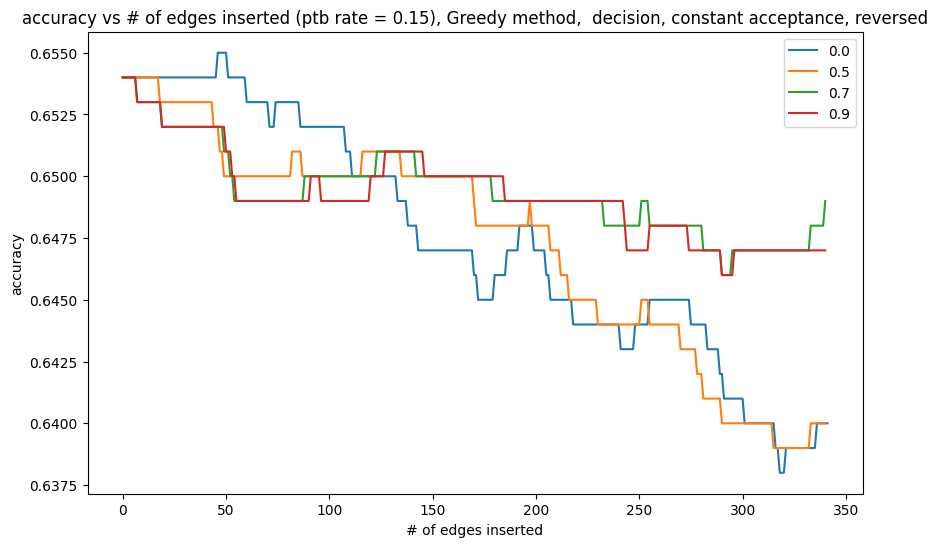

In [14]:
plot_results(split_dic_acc, ptb_rate, "Greedy", "", "constant", "accuracy", "reversed")

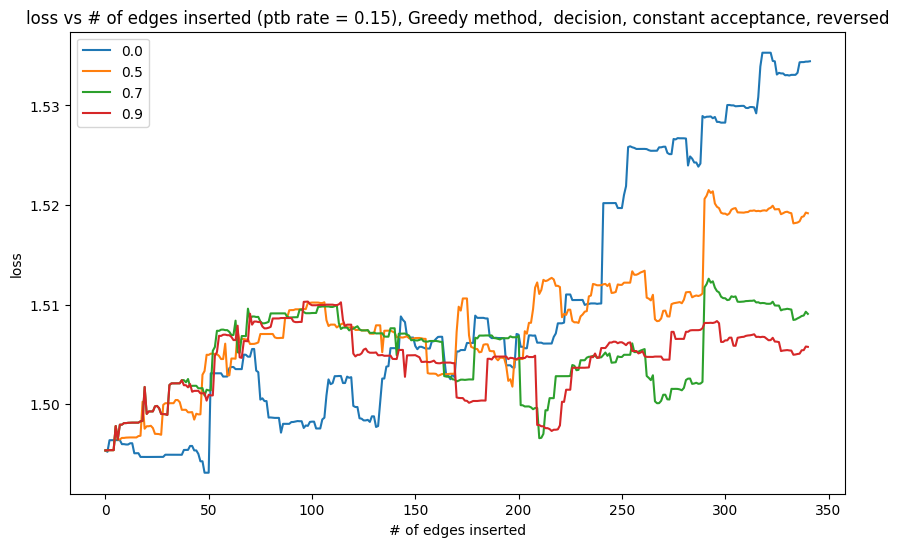

In [15]:
plot_results(split_dic_loss, ptb_rate, "Greedy", "", "constant", "loss", "reversed")

##### ideally, we could show some metric, where (change in loss after hidden for %) > (% * max change in loss)

In [16]:
split_dic_decreasing_acc = defaultdict(list)
itrs_two = defaultdict(int)
split_dic_decreasing_loss = defaultdict(list)

In [17]:
for s in splits:
    if s == 0.0:
        split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = full_metattack_acc, full_metattack_loss, full_metattack_itrs
    else:
        split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = two_phase_attack_greedy(data, train, model, s, edges_to_add, increasing_fn, device, is_reversed=True, verbose=True)

Peturbing graph...:   0%|          | 0/170 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 13, Selected: 10
Attempt: 26, Selected: 20
Attempt: 50, Selected: 40
Attempt: 60, Selected: 50
Attempt: 70, Selected: 60
Attempt: 81, Selected: 70
Attempt: 81, Selected: 70
Attempt: 91, Selected: 80
Attempt: 101, Selected: 90
Attempt: 111, Selected: 100
Attempt: 121, Selected: 110
Attempt: 131, Selected: 120
Attempt: 141, Selected: 130
Attempt: 151, Selected: 140
Attempt: 161, Selected: 150
Attempt: 171, Selected: 160


Peturbing graph...:   0%|          | 0/102 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 13, Selected: 10
Attempt: 25, Selected: 20
Attempt: 37, Selected: 30
Attempt: 37, Selected: 30
Attempt: 49, Selected: 40
Attempt: 61, Selected: 50
Attempt: 74, Selected: 60
Attempt: 75, Selected: 60
Attempt: 86, Selected: 70
Attempt: 96, Selected: 80
Attempt: 106, Selected: 90
Attempt: 116, Selected: 100
Attempt: 116, Selected: 100
Attempt: 126, Selected: 110
Attempt: 136, Selected: 120
Attempt: 147, Selected: 130
Attempt: 147, Selected: 130
Attempt: 177, Selected: 160
Attempt: 187, Selected: 170
Attempt: 197, Selected: 180
Attempt: 207, Selected: 190
Attempt: 207, Selected: 190
Attempt: 219, Selected: 200
Attempt: 229, Selected: 210
Attempt: 239, Selected: 220
Attempt: 249, Selected: 230
Attempt: 249, Selected: 230


Peturbing graph...:   0%|          | 0/34 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 13, Selected: 10
Attempt: 26, Selected: 20
Attempt: 27, Selected: 20
Attempt: 38, Selected: 30
Attempt: 51, Selected: 40
Attempt: 63, Selected: 50
Attempt: 63, Selected: 50
Attempt: 64, Selected: 50
Attempt: 65, Selected: 50
Attempt: 76, Selected: 60
Attempt: 87, Selected: 70
Attempt: 97, Selected: 80
Attempt: 107, Selected: 90
Attempt: 117, Selected: 100
Attempt: 128, Selected: 110
Attempt: 138, Selected: 120
Attempt: 148, Selected: 130
Attempt: 149, Selected: 130
Attempt: 159, Selected: 140
Attempt: 169, Selected: 150
Attempt: 180, Selected: 160
Attempt: 190, Selected: 170
Attempt: 200, Selected: 180
Attempt: 210, Selected: 190
Attempt: 221, Selected: 200
Attempt: 231, Selected: 210
Attempt: 242, Selected: 220
Attempt: 252, Selected: 230
Attempt: 262, Selected: 240
Attempt: 272, Selected: 250
Attempt: 282, Selected: 260
Attempt: 292, Selected: 270
Attempt: 302, Selected: 280
Attempt: 312, Selected: 290
Attempt: 323, Selected: 300


In [18]:
record1 = Recording(split_dic_decreasing_loss, split_dic_decreasing_acc, itrs_two, Model.GSAGE, Dataset.CITESEER, AcceptFn.INCREASING, SelectFn.NONE, Reverse.REVERSED)
record1.save(f'data_collection/{"greedy"}_{"gsage"}_{"citeseer"}_{"increasing"}_{"reversed"}_results.pkl')

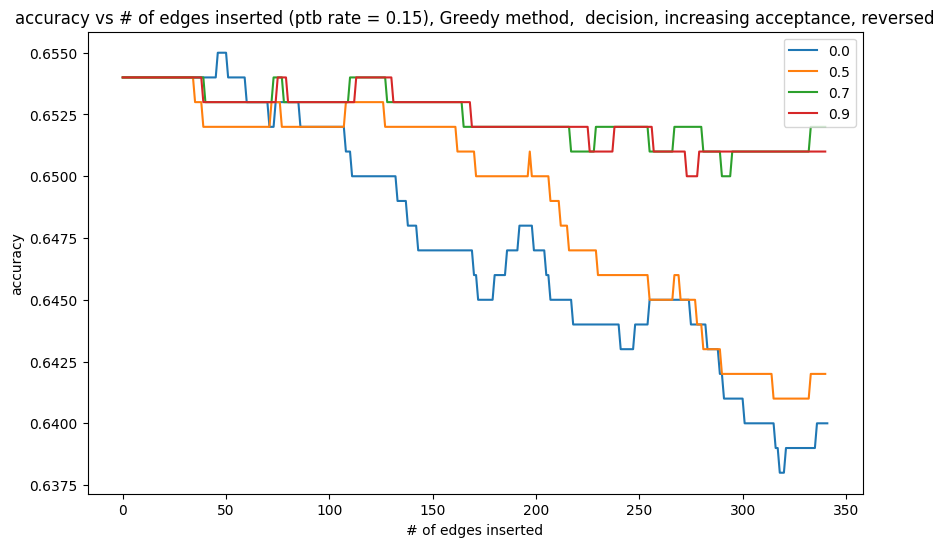

In [19]:
plot_results(split_dic_decreasing_acc, ptb_rate, "Greedy", "", "increasing", "accuracy", "reversed")

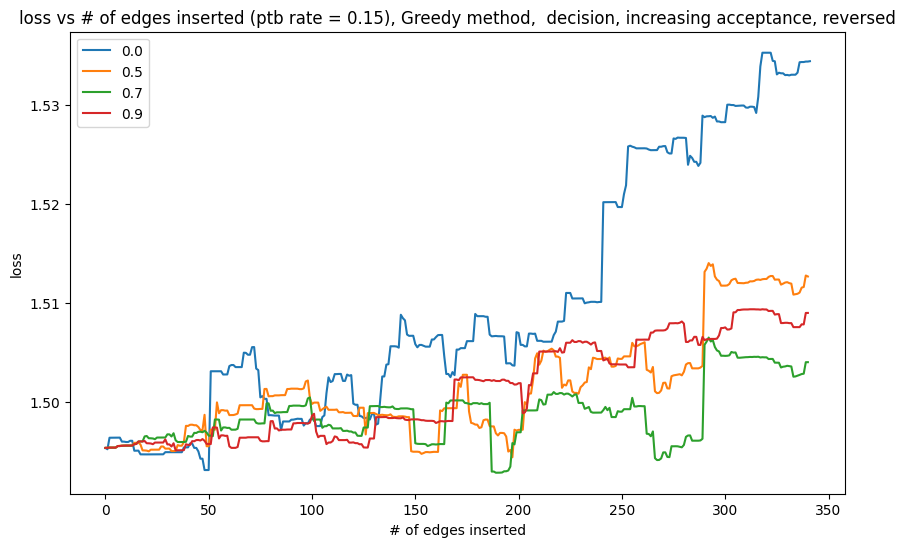

In [20]:
plot_results(split_dic_decreasing_loss, ptb_rate, "Greedy", "", "increasing", "loss", "reversed")

# regular, secondary attack, not reversed

In [21]:
splits = [0.0, 0.5, 0.7, 0.9]
# splits = [0.9]
split_dic_acc = defaultdict(list)
split_dic_loss = defaultdict(list)
itrs_one = defaultdict(int)

In [23]:
for s in splits:
    if s == 0.0:
        split_dic_acc[s], split_dic_loss[s], itrs_one[s] = full_metattack_acc, full_metattack_loss, full_metattack_itrs
    else:
        split_dic_acc[s], split_dic_loss[s], itrs_one[s] = two_phase_attack_greedy(data, train, model, s, edges_to_add, constant_fn, device, is_reversed=False, verbose=True)

Peturbing graph...:   0%|          | 0/170 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 10, Selected: 10
Attempt: 20, Selected: 20
Attempt: 30, Selected: 30
Attempt: 40, Selected: 40
Attempt: 50, Selected: 50
Attempt: 60, Selected: 60
Attempt: 70, Selected: 70
Attempt: 81, Selected: 80
Attempt: 81, Selected: 80
Attempt: 91, Selected: 90
Attempt: 101, Selected: 100
Attempt: 113, Selected: 110
Attempt: 123, Selected: 120
Attempt: 133, Selected: 130
Attempt: 143, Selected: 140
Attempt: 153, Selected: 150
Attempt: 163, Selected: 160


Peturbing graph...:   0%|          | 0/176 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/102 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 10, Selected: 10
Attempt: 10, Selected: 10
Attempt: 20, Selected: 20
Attempt: 30, Selected: 30
Attempt: 40, Selected: 40
Attempt: 50, Selected: 50
Attempt: 60, Selected: 60
Attempt: 70, Selected: 70
Attempt: 80, Selected: 80
Attempt: 91, Selected: 90
Attempt: 102, Selected: 100
Attempt: 112, Selected: 110
Attempt: 123, Selected: 120
Attempt: 133, Selected: 130
Attempt: 143, Selected: 140
Attempt: 153, Selected: 150
Attempt: 163, Selected: 160
Attempt: 173, Selected: 170
Attempt: 183, Selected: 180
Attempt: 193, Selected: 190
Attempt: 203, Selected: 200
Attempt: 213, Selected: 210
Attempt: 223, Selected: 220
Attempt: 233, Selected: 230


Peturbing graph...:   0%|          | 0/107 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/34 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 10, Selected: 10
Attempt: 10, Selected: 10
Attempt: 20, Selected: 20
Attempt: 30, Selected: 30
Attempt: 40, Selected: 40
Attempt: 50, Selected: 50
Attempt: 60, Selected: 60
Attempt: 70, Selected: 70
Attempt: 80, Selected: 80
Attempt: 91, Selected: 90
Attempt: 102, Selected: 100
Attempt: 113, Selected: 110
Attempt: 124, Selected: 120
Attempt: 134, Selected: 130
Attempt: 144, Selected: 140
Attempt: 154, Selected: 150
Attempt: 164, Selected: 160
Attempt: 174, Selected: 170
Attempt: 184, Selected: 180
Attempt: 194, Selected: 190
Attempt: 204, Selected: 200
Attempt: 214, Selected: 210
Attempt: 225, Selected: 220
Attempt: 235, Selected: 230
Attempt: 245, Selected: 240
Attempt: 255, Selected: 250
Attempt: 265, Selected: 260
Attempt: 275, Selected: 270
Attempt: 285, Selected: 280
Attempt: 295, Selected: 290
Attempt: 305, Selected: 300


Peturbing graph...:   0%|          | 0/36 [00:00<?, ?it/s]

In [24]:
record1 = Recording(split_dic_loss, split_dic_acc, itrs_one, Model.GSAGE, Dataset.CITESEER, AcceptFn.CONSTANT, SelectFn.NONE, Reverse.ATTACKED)
record1.save(f'data_collection/{"greedy"}_{"gsage"}_{"citeseer"}_{"constant"}_{"attacked"}_results.pkl')

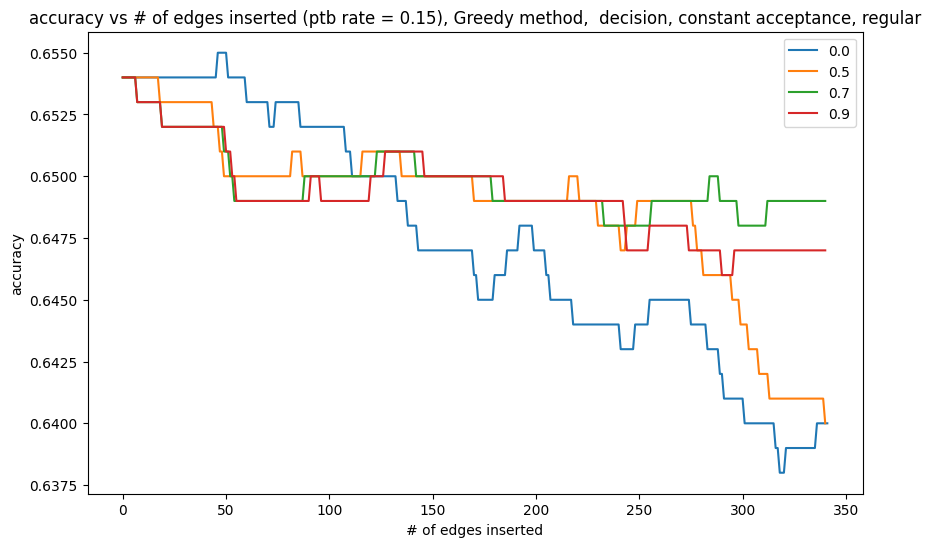

In [25]:
plot_results(split_dic_acc, ptb_rate, "Greedy", "", "constant", "accuracy", "regular")

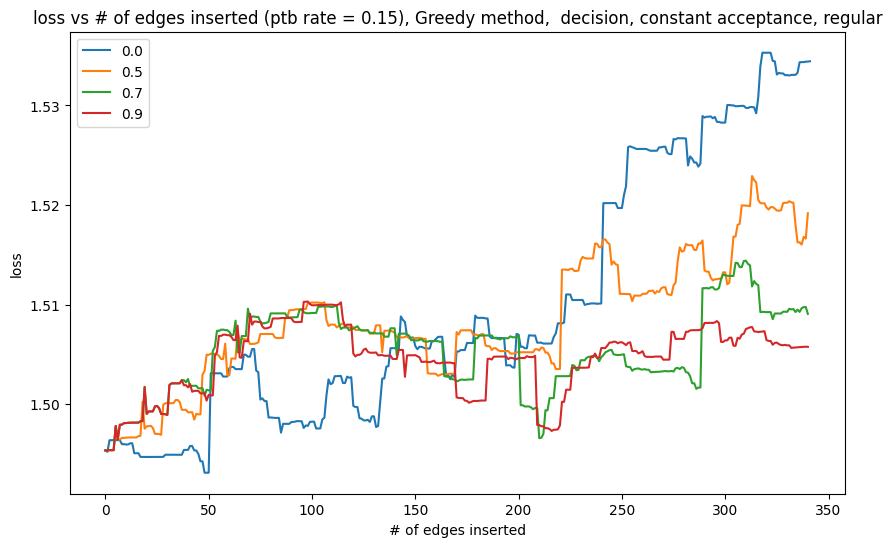

In [26]:
plot_results(split_dic_loss, ptb_rate, "Greedy", "", "constant", "loss", "regular")

##### ideally, we could show some metric, where (change in loss after hidden for %) > (% * max change in loss)

In [27]:
split_dic_decreasing_acc = defaultdict(list)
itrs_two = defaultdict(int)
split_dic_decreasing_loss = defaultdict(list)

In [28]:
for s in splits:
    if s == 0.0:
        split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = full_metattack_acc, full_metattack_loss, full_metattack_itrs
    else:
        split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = two_phase_attack_greedy(data, train, model, s, edges_to_add, increasing_fn, device, is_reversed=False, verbose=True)

Peturbing graph...:   0%|          | 0/170 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 13, Selected: 10
Attempt: 26, Selected: 20
Attempt: 38, Selected: 30
Attempt: 50, Selected: 40
Attempt: 60, Selected: 50
Attempt: 70, Selected: 60
Attempt: 81, Selected: 70
Attempt: 81, Selected: 70
Attempt: 91, Selected: 80
Attempt: 101, Selected: 90
Attempt: 111, Selected: 100
Attempt: 121, Selected: 110
Attempt: 131, Selected: 120
Attempt: 141, Selected: 130
Attempt: 151, Selected: 140
Attempt: 161, Selected: 150
Attempt: 171, Selected: 160


Peturbing graph...:   0%|          | 0/176 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/102 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 13, Selected: 10
Attempt: 25, Selected: 20
Attempt: 37, Selected: 30
Attempt: 37, Selected: 30
Attempt: 49, Selected: 40
Attempt: 61, Selected: 50
Attempt: 74, Selected: 60
Attempt: 75, Selected: 60
Attempt: 86, Selected: 70
Attempt: 96, Selected: 80
Attempt: 106, Selected: 90
Attempt: 116, Selected: 100
Attempt: 116, Selected: 100
Attempt: 126, Selected: 110
Attempt: 136, Selected: 120
Attempt: 147, Selected: 130
Attempt: 147, Selected: 130
Attempt: 157, Selected: 140
Attempt: 167, Selected: 150
Attempt: 177, Selected: 160
Attempt: 187, Selected: 170
Attempt: 197, Selected: 180
Attempt: 207, Selected: 190
Attempt: 207, Selected: 190
Attempt: 219, Selected: 200
Attempt: 229, Selected: 210
Attempt: 239, Selected: 220
Attempt: 249, Selected: 230
Attempt: 249, Selected: 230


Peturbing graph...:   0%|          | 0/107 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/34 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 13, Selected: 10
Attempt: 26, Selected: 20
Attempt: 27, Selected: 20
Attempt: 38, Selected: 30
Attempt: 51, Selected: 40
Attempt: 63, Selected: 50
Attempt: 63, Selected: 50
Attempt: 64, Selected: 50
Attempt: 65, Selected: 50
Attempt: 76, Selected: 60
Attempt: 87, Selected: 70
Attempt: 97, Selected: 80
Attempt: 107, Selected: 90
Attempt: 117, Selected: 100
Attempt: 128, Selected: 110
Attempt: 138, Selected: 120
Attempt: 148, Selected: 130
Attempt: 149, Selected: 130
Attempt: 159, Selected: 140
Attempt: 169, Selected: 150
Attempt: 180, Selected: 160
Attempt: 190, Selected: 170
Attempt: 200, Selected: 180
Attempt: 210, Selected: 190
Attempt: 221, Selected: 200
Attempt: 231, Selected: 210
Attempt: 242, Selected: 220
Attempt: 252, Selected: 230
Attempt: 262, Selected: 240
Attempt: 272, Selected: 250
Attempt: 282, Selected: 260
Attempt: 292, Selected: 270
Attempt: 302, Selected: 280
Attempt: 312, Selected: 290
Attempt: 323, Selected: 300


Peturbing graph...:   0%|          | 0/36 [00:00<?, ?it/s]

In [29]:
record1 = Recording(split_dic_decreasing_loss, split_dic_decreasing_acc, itrs_two, Model.GSAGE, Dataset.CITESEER, AcceptFn.INCREASING, SelectFn.NONE, Reverse.ATTACKED)
record1.save(f'data_collection/{"mcmc"}_{"gsage"}_{"citeseer"}_{"increasing"}_{"attacked"}_results.pkl')

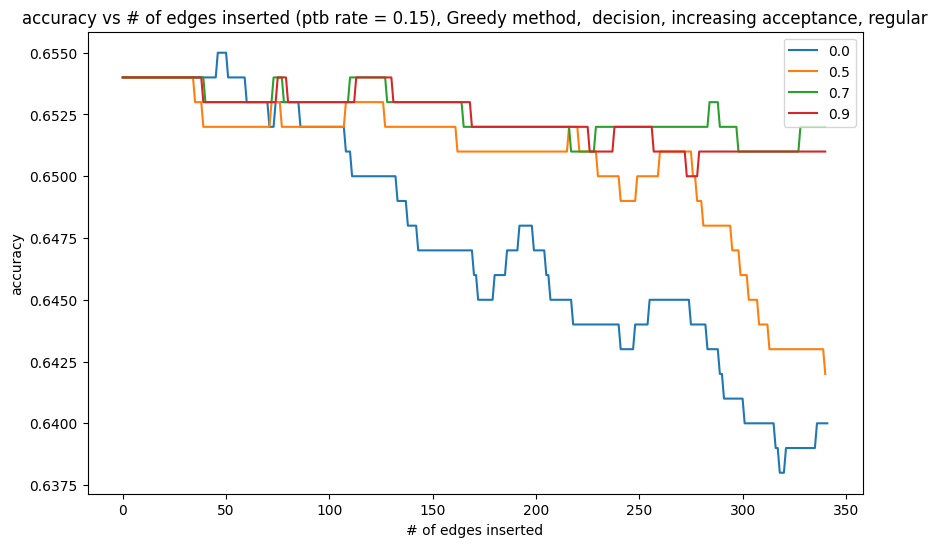

In [30]:
plot_results(split_dic_decreasing_acc, ptb_rate, "Greedy", "", "increasing", "accuracy", "regular")

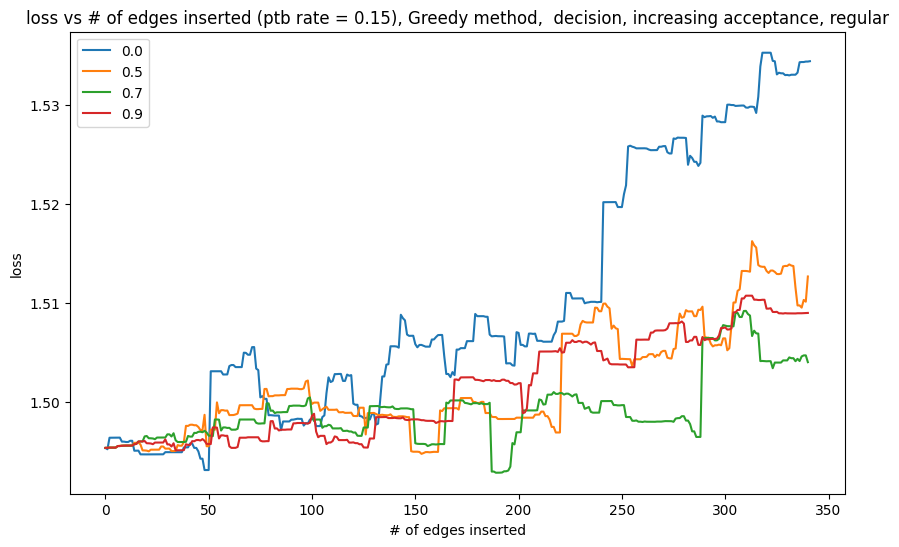

In [31]:
plot_results(split_dic_decreasing_loss, ptb_rate, "Greedy", "", "increasing", "loss", "regular")